In [136]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt

# Number of levels and systems
num_levels = 2
num_systems = 2

# cross Kerr matrix 
cross_kerrs = 2*np.pi*np.array([[ 0.00000000e+00, 2.69516637e-04, 1.26486438e-04, 8.86845176e-05, 4.26936404e-05, 1.94041328e-05, -1.95956248e-05], [-1.77543592e-04, 0.00000000e+00, -6.92266452e-05, -7.10978126e-05, 1.37913777e-05, -2.56223707e-05, 9.10903529e-07], [-7.56355942e-05, -4.42189013e-05, 0.00000000e+00, -2.45449305e-05, -4.28864355e-06, 2.24512793e-06, -3.33552244e-06], [ 6.10648017e-05, 4.56428583e-05, 1.96973208e-05, 0.00000000e+00, 2.41548015e-06, -1.08904643e-05, -6.20592017e-06], [-3.72488668e-05, -4.62192947e-05, -3.77809419e-05, -1.58034621e-05, 0.00000000e+00, -2.52649638e-05, -2.20498490e-06], [-4.31597553e-05, -1.65832342e-05, -4.06943788e-05, 1.21448311e-05, -1.92766876e-05, 0.00000000e+00, 1.27297852e-05], [-5.42085347e-06, -3.00407857e-05, -7.10933782e-06, -2.45232181e-05, 8.53857371e-06, -1.07023464e-05, 0.00000000e+00]])
cross_kerrs = np.array(cross_kerrs) 
print(cross_kerrs)

T1s =   np.array([ 358.3, 1254.8,  799. ,  597.4,  355.7,  589.5,  371.2])

[[ 0.00000000e+00  1.69342297e-03  7.94737729e-04  5.57221258e-04
   2.68252054e-04  1.21919762e-04 -1.23122942e-04]
 [-1.11553929e-03  0.00000000e+00 -4.34963840e-04 -4.46720732e-04
   8.66537817e-05 -1.60990103e-04  5.72337567e-06]
 [-4.75232454e-04 -2.77835551e-04  0.00000000e+00 -1.54220347e-04
  -2.69463421e-05  1.41065548e-05 -2.09577056e-05]
 [ 3.83681465e-04  2.86782537e-04  1.23761917e-04  0.00000000e+00
   1.51769094e-05 -6.84268053e-05 -3.89929464e-05]
 [-2.34041533e-04 -2.90404393e-04 -2.37384659e-04 -9.92960809e-05
   0.00000000e+00 -1.58744449e-04 -1.38543287e-05]
 [-2.71180740e-04 -1.04195533e-04 -2.55690323e-04  7.63082243e-05
  -1.21119000e-04  0.00000000e+00  7.99835993e-05]
 [-3.40602269e-05 -1.88751823e-04 -4.46692869e-05 -1.54083924e-04
   5.36494409e-05 -6.72448257e-05  0.00000000e+00]]


In [137]:
# Identity operator for a 2-level system
I = qeye(num_levels)

# Pauli-Z operator for a 2-level system
Z = sigmaz()

# Create the Hamiltonian for each system (assuming no individual Hamiltonian terms for simplicity)

H0 = 0* tensor([Z if k == 0  else I for k in range(num_systems)])

# ZZ interaction term
def zz_interaction(i, j):
    coeff = np.abs(cross_kerrs[i][j])
    print(coeff)
    return coeff * tensor([Z - I if k == i or k == j else I for k in range(num_systems)]) 


# collapse operators
a = destroy(num_levels)

# Create a list of collapse operators for T1 loss
collapse_operators = [tensor([np.sqrt(2 * np.pi * 1/T1s[k]) *  a if i == k else I for i in range(num_systems)]) for k in range(num_systems)]


# Add ZZ interactions between each pair of systems
H = H0
for i in range(num_systems):
    for j in range( num_systems):
        if i != j:
            H += zz_interaction(i, j)
            #print(zz_interaction(i, j))
        else: pass 

print(H)

0.001693422973638854
0.0011155392886382871
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.01123585]]


In [168]:
ground_state = tensor([basis(num_levels, 1) for i in range(num_systems)])  # All systems in the ground state
plus = (basis(num_levels, 0) + basis(num_levels, 1)).unit()  # Plus state
minus = (basis(num_levels, 0) - basis(num_levels, 1)).unit()  # Minus state

def get_plus_trajector(initial_state, tlist): 
    '''perform time evolution '''
    
    #initial_state = tensor([plus if i == 0 else basis(num_levels, 0)for i in range(num_systems)])  # First system in the plus state, others in the ground state

    # Projection operators for the 0 and 1 states of the first qubit
    P0 = tensor([basis(2, 0) * basis(2, 0).dag()] + [I for _ in range(num_systems - 1)])
    P1 = tensor([basis(2, 1) * basis(2, 1).dag()] + [I for _ in range(num_systems - 1)])

    Pplus = tensor([plus * plus.dag()] + [I for _ in range(num_systems - 1)])
    Pminus = tensor([minus * minus.dag()] + [I for _ in range(num_systems - 1)])

    # Perform the time evolution
    result = mesolve(H, initial_state, tlist, collapse_operators[1:],
     [Pplus, Pminus])


    # retturn plus trajectory
    return result.expect[0], result.expect[1]

def plot_all_trajectories(trajectories1, trajectories2, tlist, labels):
    '''plot all trajectories'''
    %matplotlib widget
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

    for idx, trajectory in enumerate(trajectories1):
        ax1.plot(tlist, trajectory, label=labels[idx])
    ax1.axhline(y=0, color='black', linestyle='--')
    ax1.axhline(y=1, color='black', linestyle='--')
    ax1.set_xlabel('Time (mus)')
    ax1.set_ylabel('Population')
    ax1.set_title('Time evolution of the + population')

    for idx, trajectory in enumerate(trajectories2):
        ax2.plot(tlist, trajectory, label=labels[idx])
    ax2.axhline(y=0, color='black', linestyle='--')
    ax2.axhline(y=1, color='black', linestyle='--')
    ax2.set_xlabel('Time (mus)')
    ax2.set_ylabel('Population')
    ax2.set_title('Time evolution of the - population')
    plt.legend()

    plt.tight_layout()
    plt.show()
    return  plt.figure()

def build_initial_state(systems, state_idxs):
    '''build initial state
    
    state_idxs = [0,1,2,3]
    corresponding states = [0, 1, plus, minus]
    '''
    mode_states = []
    for mode in range(num_systems): 
        if state_idxs[mode] == 0: 
            mode_states.append(basis(num_levels, 0))
        elif state_idxs[mode] == 1: 
            mode_states.append(basis(num_levels, 1))
        elif state_idxs[mode] == 2: 
            mode_states.append(plus)
        elif state_idxs[mode] == 3: 
            mode_states.append(minus)
    # print(mode_states)

    return tensor(mode_states)


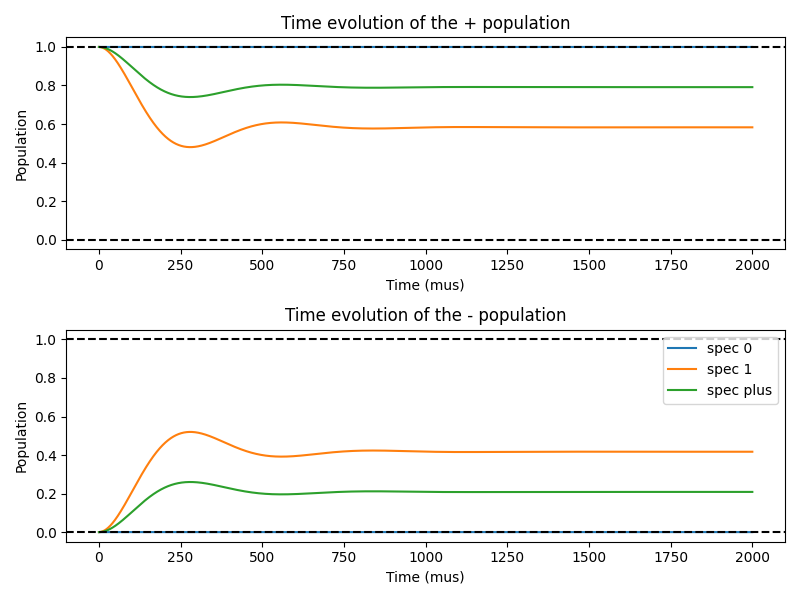

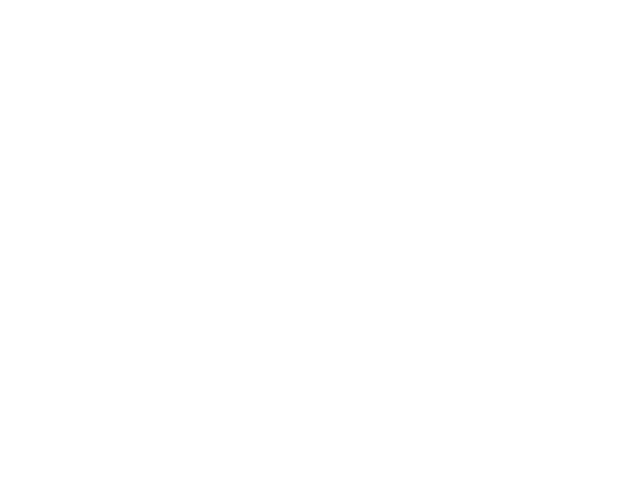

In [169]:
# Time evolution parameters
tlist = np.linspace(0, 2000, 4000)  # Time from 0 to 10 with 100 points

# Perform the time evolution

initial_states = [build_initial_state(num_systems, [2, 0, 0, 0, 0, 0, 0]),
                 build_initial_state(num_systems, [2, 1,1,1,1,1,1]),
                 build_initial_state(num_systems, [2, 2,2,2,2,2,2]),
                # build_initial_state(num_systems, [2, 3,2,3,1,3,0])
                ]
state_labels = ['spec 0', 'spec 1', 'spec plus', 'spec random']

trajectories1 = []
trajectories2 = []
for idx, initial_state in enumerate(initial_states):
    trajectory1, trajectory2 = get_plus_trajector(initial_state, tlist)
    trajectories1.append(trajectory1)
    trajectories2.append(trajectory2)

trajectories = [get_plus_trajector(initial_state, tlist) for initial_state in initial_states]
%matplotlib widget
fig = plot_all_trajectories(trajectories1, trajectories2, tlist, state_labels)

In [140]:
2 * np.pi * 300

1884.9555921538758

In [59]:
1/0.3

3.3333333333333335

# Function curves

$f(t) = \cos((\Omega + e^{-\kappa t }\chi) t)$

<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
/var/folders/qv/2zlrl3v97s9_ht7wrdl_fgp00000gn/T/ipykernel_38139/2715959136.py:7: SyntaxWarning: invalid escape sequence '\c'
  '''


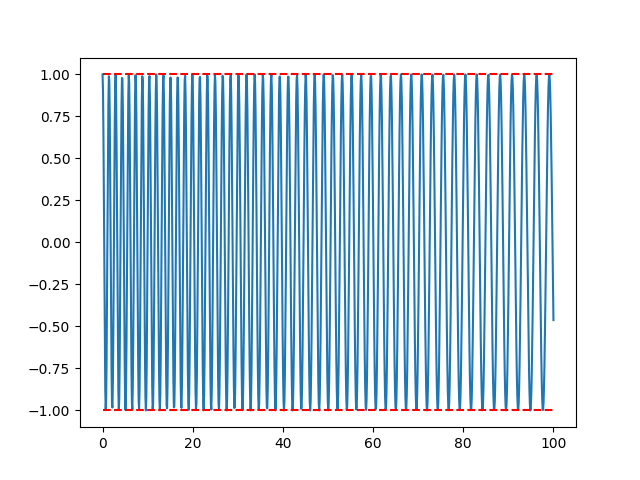

In [163]:
fig = plt.figure()
kappa = 1/200 # freq
chi1  = 2 * np.pi * 0.5
chi2  = 2 * np.pi * 0
omega = 2 * np.pi * 0.2
def func(t): 
    '''
    $f(t) = \cos((\Omega + e^{-\kappa t }\chi) t)$
    '''
    return (np.cos((omega + np.exp(-1 * kappa*t)*chi1 +np.exp(-1 * kappa*t)*chi2 ) * t) )#+ np.cos((omega + np.exp(-1 * kappa*t)*chi2) * t))/2

tlist = np.linspace(0, 100, 1000)
plt.plot(tlist, func(tlist))
plt.hlines(y=-1, xmin=0, xmax=100, color='r', linestyle='--')
plt.hlines(y=1, xmin=0, xmax=100, color='r', linestyle='--')
plt.show()


In [6]:
initial_state

NameError: name 'initial_state' is not defined